In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sys.path.append("\content\drive\MyDrive\DS2500 project\DS2500 project datasets")

dir = "/content/drive/MyDrive/DS2500 project"
name = "crime2023.csv"

In [ ]:
# specify the path then assign the file of the path to a pandas dataframe
path = os.path.join(dir, name)

df = pd.read_csv(path)
df.head()

<ipython-input-17-f2663c95b997>:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,_id,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,1,232007173,3115,NaN,INVESTIGATE PERSON,B3,,0,2023-01-27 22:44:00+00,2023,1,Friday,22,NaN,FAVRE ST,42.271661,-71.099535,"(42.271661031027065, -71.09953455161765)"
1,2,232004454,3301,NaN,VERBAL DISPUTE,B2,316,0,2023-01-17 20:21:00+00,2023,1,Tuesday,20,NaN,HAROLD ST,42.312596,-71.092876,"(42.3125962960786, -71.09287583752645)"
2,3,232006290,3115,NaN,INVESTIGATE PERSON,A1,,0,2023-01-24 00:00:00+00,2023,1,Tuesday,0,NaN,HANOVER ST,42.365699,-71.052892,"(42.3656993584582, -71.05289203191269)"
3,4,232024939,3114,NaN,INVESTIGATE PROPERTY,B3,,0,2023-03-31 17:14:00+00,2023,3,Friday,17,NaN,BLUE HILL AVE,42.292788,-71.088520,"(42.29278799134922, -71.08851953962399)"
4,5,232006708,423,NaN,ASSAULT - AGGRAVATED,B2,,0,2023-01-26 09:00:00+00,2023,1,Thursday,9,NaN,HUTCHINGS ST,42.310269,-71.089311,"(42.310268910354935, -71.08931055058088)"


1. What are the peak days and times for various types of crimes?
2. Are there specific time intervals during the day when crime incidents transition sharply (e.g., from low to high activity),
and do these transitions vary by crime type?
3. Which features (e.g., day of the week, district, time, type of crime) are the most important for predicting the frequency of crime incidents?
4. What is the RMSE of a predictive model forecasting the daily number of crime incidents, and how does it compare to other error metrics like MAE (Mean Absolute Error)?


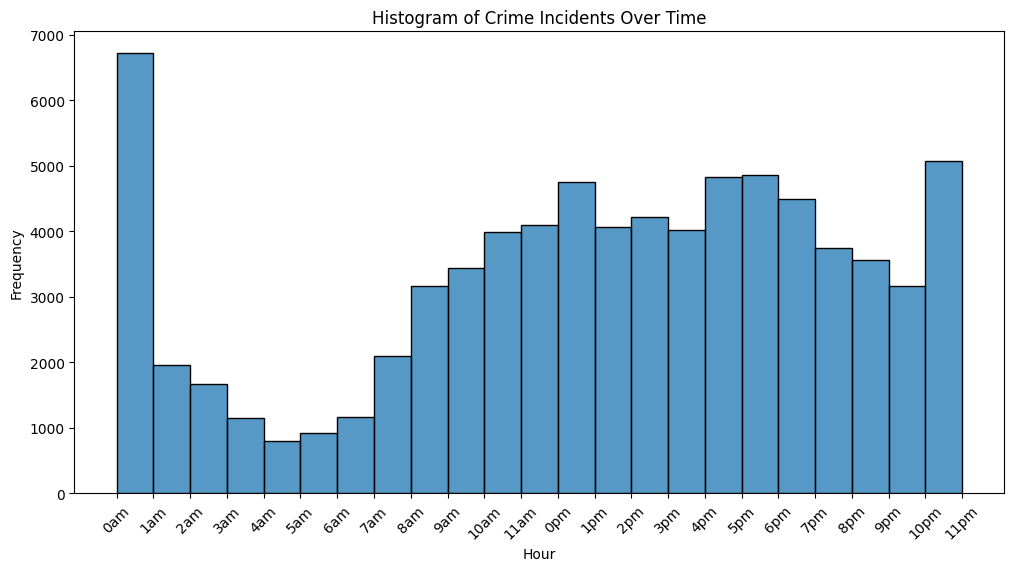

In [ ]:
df = df[df["YEAR"]!= 2024]

# Create the histogram of crimes by the hour they're committed
plt.figure(figsize=(12, 6))
sns.histplot(df['HOUR'], bins=23)
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.title('Histogram of Crime Incidents Over Time')
plt.xticks([i for i in range(0,24)], [str(i%12) + "pm" if i//12==1 else str(i%12) + "am" for i in range(0,24)])
plt.xticks(rotation=45)
plt.show()

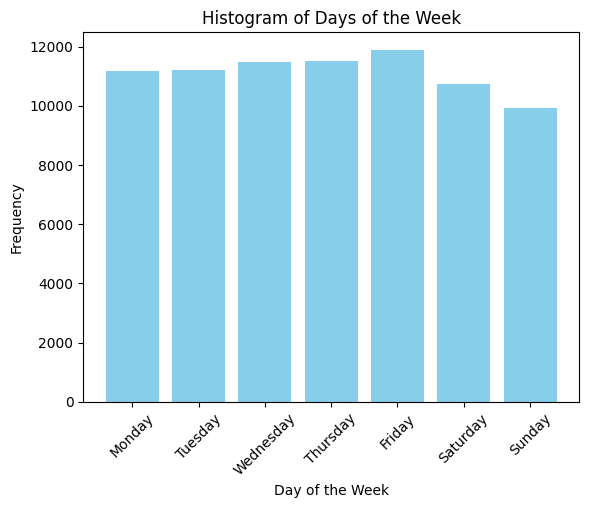

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Count how many crimes there are for each day
day_counts = df['DAY_OF_WEEK'].value_counts()
# remove all spaces in key, reorder dictionary for graphing
day_counts.index = day_counts.index.str.strip()
day_counts = day_counts.reindex(day_order, fill_value=0)

# Plot the histogram
plt.bar(day_counts.index, day_counts.values, color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Histogram of Days of the Week')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# only get the first element from offense descriptions when split by "-"
df['OFFENSE_DESCRIPTION'] = df['OFFENSE_DESCRIPTION'].apply(lambda row: row.split("-")[0].replace(" ",""))

In [ ]:
# group data by 'OFFENSE_DESCRIPTION' and 'HOUR' if not already grouped
crime_by_hour = df.groupby(['OFFENSE_DESCRIPTION', 'HOUR']).size().reset_index(name='Counts')

# get unique offense descriptions
offence_descriptions = crime_by_hour['OFFENSE_DESCRIPTION'].unique()

# create subplots for each offense description
plt.figure(figsize=(30, 300))  # Adjust figure size as needed
for i, offence in enumerate(offence_descriptions):
    plt.subplot(len(offence_descriptions) // 2 + 1, 2, i + 1)  # Adjust layout as needed

    # filter data for the current offence
    offence_data = crime_by_hour[crime_by_hour['OFFENSE_DESCRIPTION'] == offence]

    # expand data for histogram plotting
    expanded_data = offence_data.loc[offence_data.index.repeat(offence_data['Counts'])].reset_index(drop=True)

    # plot histogram for the offense
    sns.histplot(expanded_data['HOUR'], bins=23, kde=False, color='skyblue')
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {offence} by Hour')
    plt.xticks(range(24), [str(i % 12 or 12) + ("pm" if i // 12 == 1 else "am") for i in range(24)], rotation=45)

plt.show()

## Combine all three of our findings
## Models that predicts frequency of crime based on: month, hour of day, location

In [ ]:
# create the features of the model, normalize data for location
features = df[['MONTH', 'HOUR', 'Lat', 'Long']].copy()
# round lat and long since they are the precise coordinates
features['Lat'] = features['Lat'].round(3)
features['Long'] = features['Long'].round(3)
# normalize all data
normalized = (features-features.min())/(features.max()-features.min())
# drop all nan rows
normalized = normalized.dropna()
print(normalized.shape)
normalized.head()

(72309, 4)


,MONTH,HOUR,Lat,Long
0,0.000000,0.956522,0.445946,0.351111
1,0.000000,0.869565,0.630631,0.382222
2,0.000000,0.000000,0.869369,0.560000
3,0.181818,0.739130,0.540541,0.400000
4,0.000000,0.391304,0.617117,0.400000


In [ ]:
# create a frequency column based on the features columns
target = normalized.groupby(['MONTH', 'HOUR', 'Lat', 'Long'])['MONTH'].transform('count')
target.head()

,MONTH
0,1
1,1
2,1
3,2
4,1


# KNN Modelling

In [ ]:
# split data and then create a KNN model
X_train, X_test, y_train, y_test = train_test_split(normalized, target,test_size=0.3, random_state=0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7531461761858664

In [ ]:
k = range(1, 10)
accuracies = []

for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

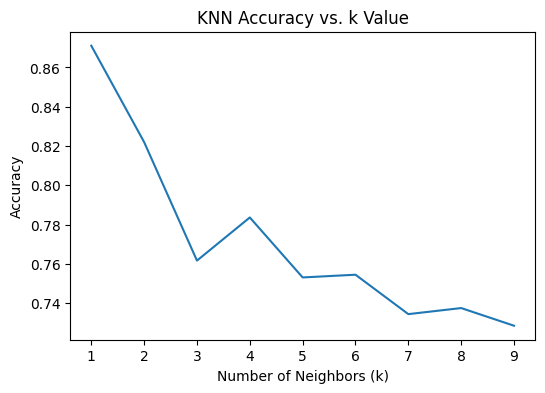

In [ ]:
# Plot the accuracy scores for different amount of neighbors
plt.figure(figsize=(6,4))
plt.plot(k, accuracies)
plt.xlabel("Number of Neighbors")
plt.xticks(k)
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs. k Value")
plt.show()